这里使用taobao.com（淘宝网）从2009年1月1日至2015年12月31日的每日访问IP量数据建模，2016全年数据用于测试结果（数据源：alexa.cn）。

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

以pandas读取excel数据（Prophet要求时间栏命名为ds，数值栏命名为y）。

In [2]:
df = pd.read_csv('../datasets/taobao_ip.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [3]:
df.head()

,ds,排名,每百万网民访问该站的人数,每百万受访网页该站网页数,人均浏览页面数,y
0,2009-01-01,43,12900,3239,17.8,7224000
1,2009-01-02,41,12700,4030,22.7,7112000
2,2009-01-03,41,12800,3811,20.8,7168000
3,2009-01-04,39,13500,4012,20.9,7560000
4,2009-01-05,37,13700,3957,20.5,7672000


将DataFrame数据传入Prophet大概耗费1~5秒。

In [4]:
m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


使用Prophet.make_future_dataframe命令将时间栏延长365天用以预测。

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3312,2017-12-27
3313,2017-12-28
3314,2017-12-29
3315,2017-12-30
3316,2017-12-31


**注意**：切记这里是默认使用每日数据进行拟合，若你希望对月度数据进行拟合，则需调整freq参数：

future=m.make_future_dataframe(periods=120, freq='M')

Forecast命令预测结果如下,其中yhat列为拟合结果，[yhat_lower，yhat_upper]为预测区间：

In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3312,2017-12-27,2.190691e+07,1.680974e+07,2.644016e+07
3313,2017-12-28,2.176952e+07,1.637060e+07,2.678107e+07
3314,2017-12-29,2.153504e+07,1.646445e+07,2.621233e+07
3315,2017-12-30,2.201091e+07,1.683355e+07,2.662087e+07
3316,2017-12-31,2.209634e+07,1.643760e+07,2.706549e+07


绘制趋势图：

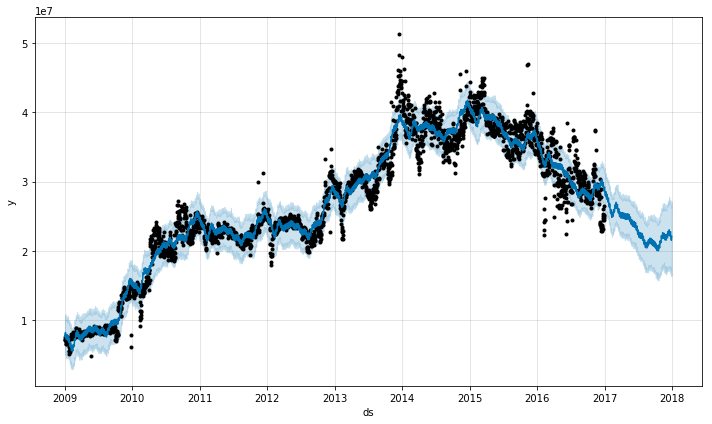

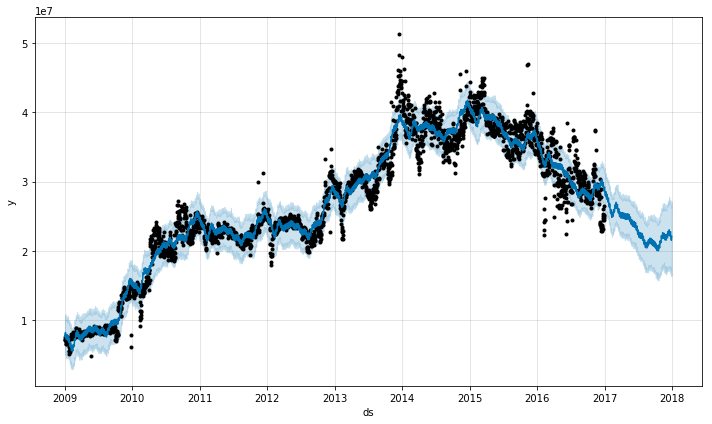

In [7]:
m.plot(forecast)

年度趋势图：

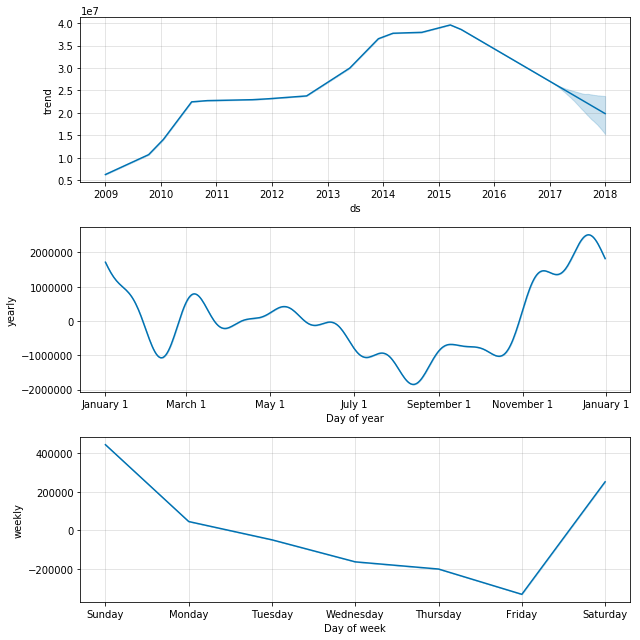

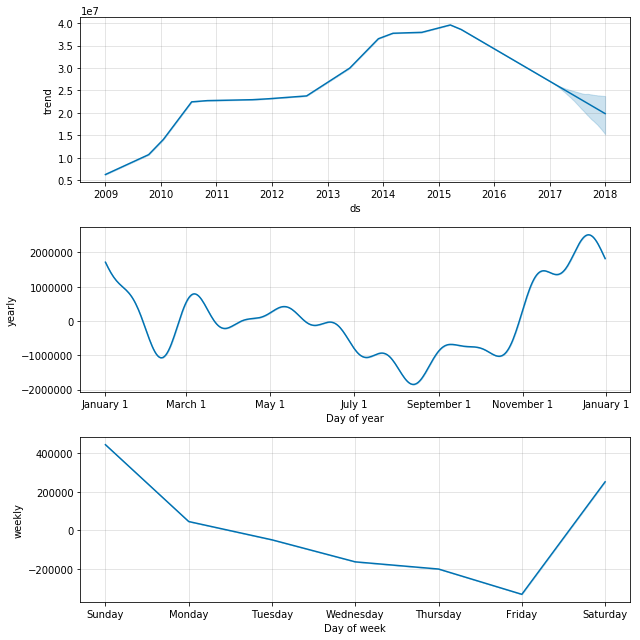

In [8]:
m.plot_components(forecast)

周流量基本集中在周末。

近年淘宝网日流量增势见顶，有下降趋势。

由上图可知每年淘宝网浏览高峰在春节及11月前后（双十一购物节）。

你可能已经注意到了，在上述例子中Prophet会自动检测数据中的趋势变化点，并在此基础上修正趋势，我们可以通过changepoint_prior_scale参数来调整修正幅度。Documents对修正机理的简述如下：

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

然而如果参数选得不恰当，容易导致overfit 或者underfit。

默认的changepoint_prior_scale参数为0.05，当我们将其0.5，预测区间过大，发生过拟合（是的，在这里预测区间大小可以作为是否发生过拟合的表征）。



INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


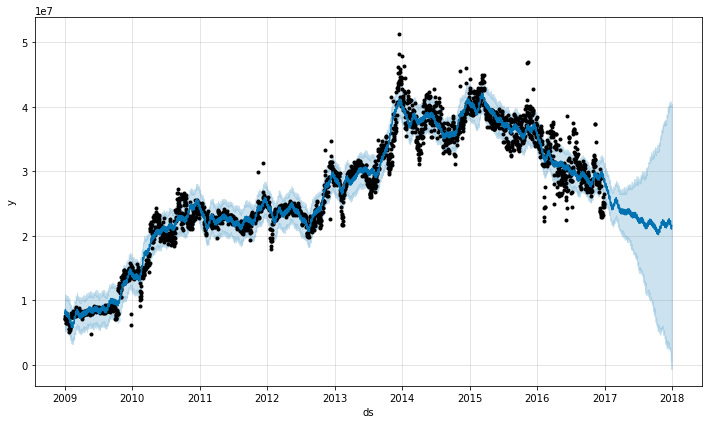

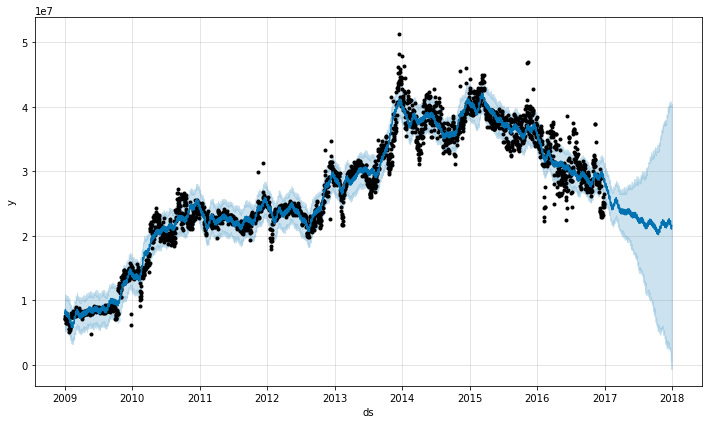

In [9]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
m.plot(forecast)

考虑节假日

如果你想在分析中囊括重要的节假日（诸如双十一购物节等会对流量产生重大影响的时间点），以DataFrame的形式传入假期数据，并通过holidays_prior_scale参数调整该节日在拟合中的重要性。该参数默认值为10，过大可能发生过拟合。

In [10]:
holidays = pd.DataFrame({
    'holiday': 'double11',
    'ds': pd.to_datetime(['2009-11-11', '2010-11-11', '2011-11-11', '2012-11-11', '2013-11-11', '2014-11-11', '2015-11-11', '2016-11-11'])
})
m = Prophet(holidays=holidays, holidays_prior_scale=0.2).fit(df)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**注意**：需同时传入历史的节日日期以及待预测的节日日期，否则，Prophet在预测时不会包含该节日。

模型修正结果如下：

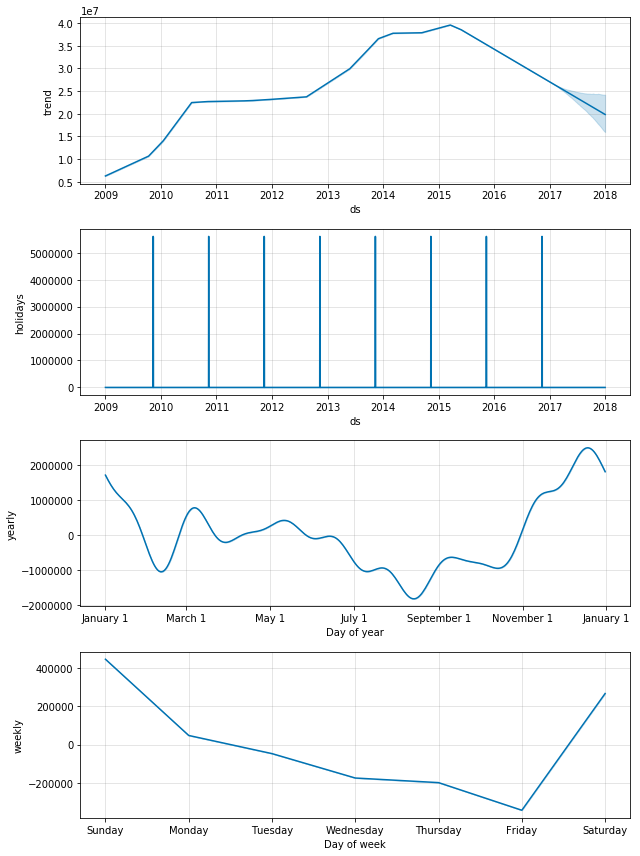

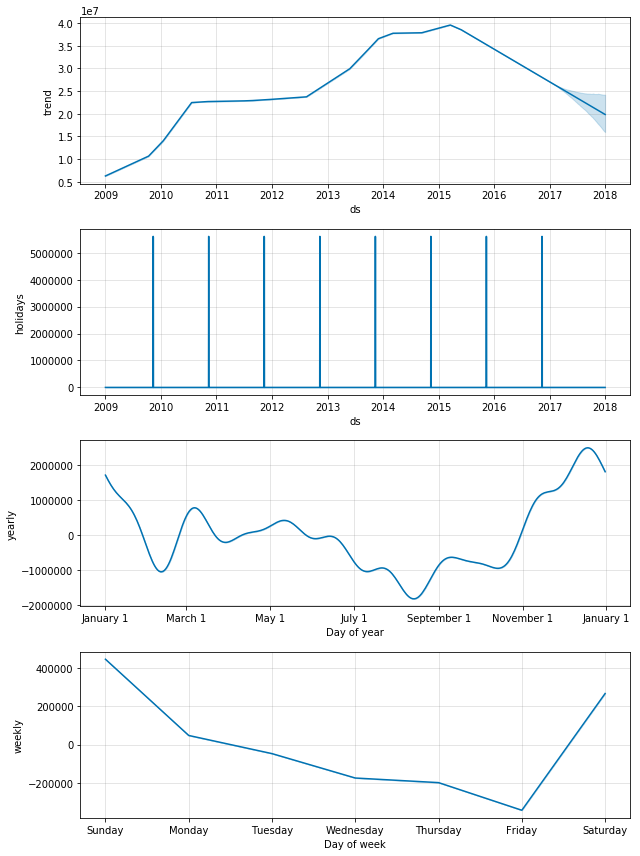

In [11]:
m.plot_components(forecast)

**不确定性**

另外，在估计yhat时，由于估计的不确定性，会同时返回一个预测区间[yhat_lower，yhat_upper]，这里的不确定性主要来源于三方面：

1.趋势的不确定性

2.季度估计的不确定性

3.可加的观测噪音

其中，通过调整interval_width参数可以变换不确定性区间的宽度。

同时通过调整mcmc.samples参数进行贝叶斯抽样，可以获得季度性的不确定性。

**注意**：如果不对mcmc.samples参数进行设置，则默认只考虑趋势不确定性及可加的观测噪音。抽样时间较长，将运行10分钟左右。

In [12]:
m = Prophet(mcmc_samples=500)
forecast = m.fit(df).predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


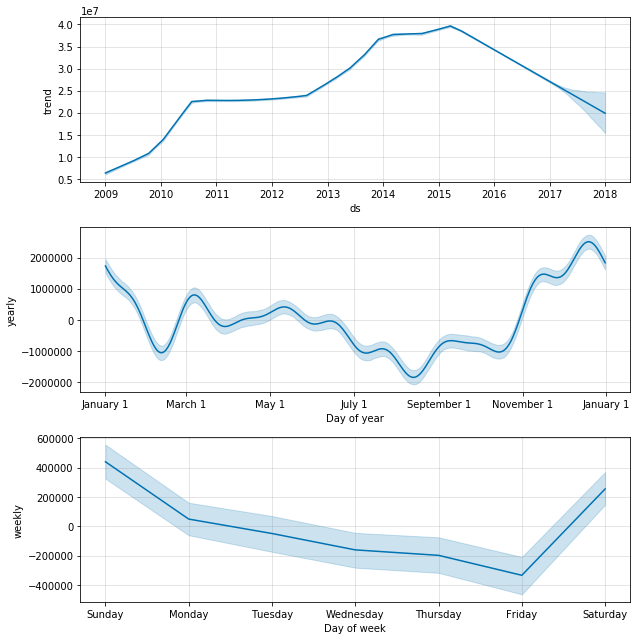

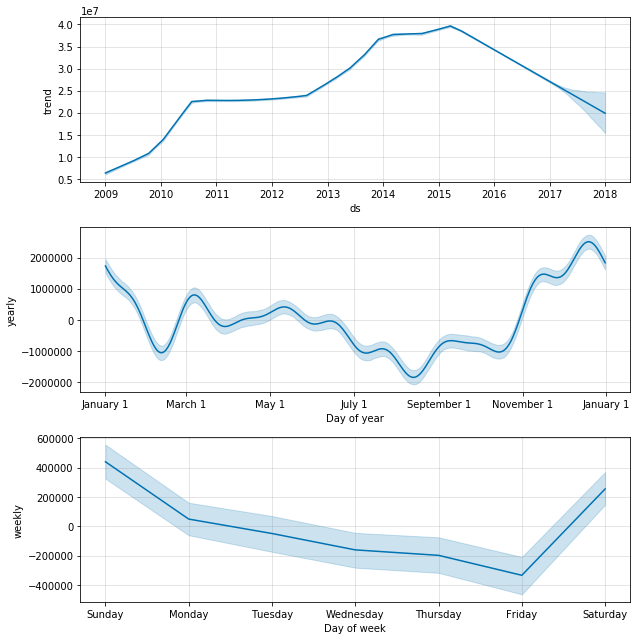

In [13]:
m.plot_components(forecast)